In [13]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import os
from os.path import basename, splitext
from utils.utils import PatternRegression
from sklearn.model_selection import train_test_split as tts
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', 40)

from utils.shift import *
from utils.age import *

In [2]:
#first dataset
p = '/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/data_joined.csv'
dfa1 = pd.read_csv(p, index_col=0)
meta1 = pd.read_csv('/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/descriptions_samples.csv', 
                   index_col=0)
dfa1 = dfa1[meta1.index]
print('Age 1, N sites', len(dfa1.index))

#second dataset
dfa2 = pd.read_csv('data/GSE40279/GSE40279_average_beta.txt', sep='\t', index_col=0)
meta2 = pd.read_csv('data/GSE40279/GSE40279_metadata.csv', index_col=0).set_index('source_name_ch1')
meta2['age'] = meta2['characteristics_ch1.0.age (y)'].astype(int)
dfa = dfa2[meta2.index]
print('Age 2, N sites', len(dfa2.index))

Age, N sites 450203


In [5]:
#get clocks
#read all clock models
paths = glob('methylclock/data/*.rda')
stoplist = ['coefLeeGA', 'coefTL']
clocks = {}
for p in paths:
    name = splitext(basename(p))[0]
    if name in stoplist:
        continue
    if not(name.__contains__('coef')):
        continue
    rda = pyreadr.read_r(p) # also works for Rds, rda
    clock = rda[name].set_index('CpGmarker')
    n_cpg = len([i for i in clock.index if 'Intercept' not in i])
    new_name = f"{name.split('coef')[1]} clock ({n_cpg} CpGs)"
    clocks[new_name] = clock

In [7]:
#train other models
cname = 'Hannum clock (71 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfa1.index).intersection(dfa2.index)

Xa1_clock = dfa1.loc[sites].T
Xa2_clock = dfa2.loc[sites].T

In [8]:
pca = PCA(2)
# Xpa = pca.fit_transform(Xa_clock)
# Xpr = pca.transform(Xr_clock)
pca.fit(Xa1_clock.append(Xa2_clock))
Xpa1 = pca.transform(Xa1_clock)
Xpa2 = pca.transform(Xa2_clock)

ya1 = meta1[f'age']
ya2 = meta2[f'age']

pvar = np.round(pca.explained_variance_ratio_, 2)
pvar

/tmp/ipykernel_79588/1880068414.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca.fit(Xa1_clock.append(Xa2_clock))


array([0.59, 0.1 ])

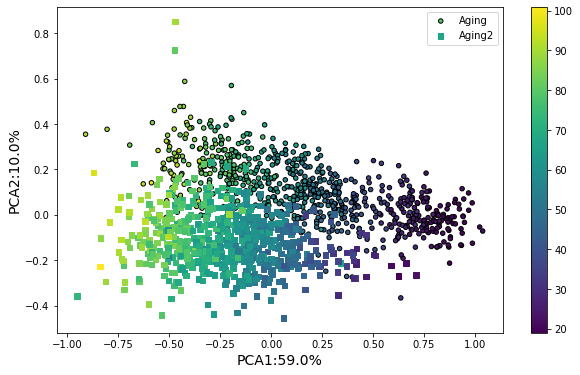

In [12]:
# fig = plt.figure(figsize=(10, 6))
# plt.scatter(Xpa1[:, 0], Xpa1[:, 1], c=ya1, s=20, label='Aging', edgecolors='black')
# plt.scatter(Xpa2[:, 0], Xpa2[:, 1], c=ya2, marker='s', s=30, label='Aging2')
# plt.xlabel(f'PCA1:{pvar[0]*100}%', fontsize=14)
# plt.ylabel(f'PCA2:{pvar[1]*100}%', fontsize=14)
# plt.legend()
# plt.colorbar()

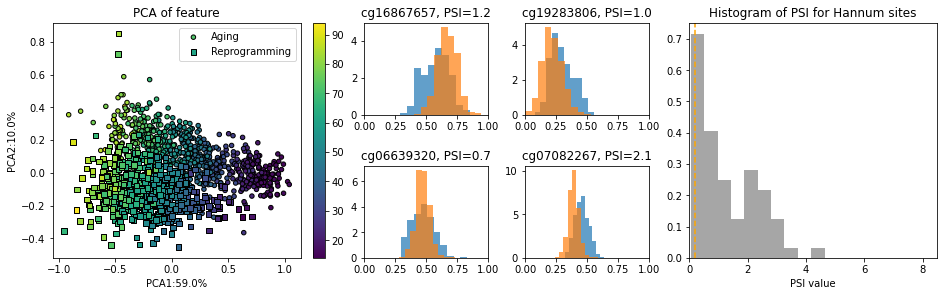

In [14]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(13, 4), constrained_layout=True)
gs = GridSpec(2, 6, figure=fig) 
ax0 = fig.add_subplot(gs[:, :2])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[0, 3])
ax3 = fig.add_subplot(gs[1, 2])
ax4 = fig.add_subplot(gs[1, 3])
ax5 = fig.add_subplot(gs[:, 4:])

# ax0 - PCA
ax0.set_title('PCA of feature')

z1_plot = ax0.scatter(Xpa1[:, 0], Xpa1[:, 1], c=ya1, s=20, label='Aging', edgecolors='black')
ax0.scatter(Xpa2[:, 0], Xpa2[:, 1], c=ya2, marker='s', s=30, label='Reprogramming', edgecolors='black')
ax0.set_xlabel(f'PCA1:{round(pvar[0]*100, 2)}%')
ax0.set_ylabel(f'PCA2:{round(pvar[1]*100, 2)}%')
ax0.legend()
plt.colorbar(z1_plot, ax=ax0)


#top from Hannum clocks sites by absolute pearson correlation with age
selected_sites = ['cg16867657', 'cg19283806', 'cg06639320', 'cg07082267']

#examples of sites + PSIs
for k, ax_ in enumerate([ax1, ax2, ax3, ax4]): 
    psi = calculate_shift(np.asarray(Xa1_clock[selected_sites[k]])[:, None], 
                          np.asarray(Xa2_clock[selected_sites[k]])[:, None],
                          metric_type='psi'
                          ).item()
    ax_.hist(Xa1_clock[selected_sites[k]], density=True, alpha=0.7)
    ax_.hist(Xa2_clock[selected_sites[k]], density=True, alpha=0.7)
    ax_.set_title(f'{selected_sites[k]}, PSI={round(psi, 1)}')
    ax_.set_xlim([0, 1])


# ax5 - overall PSI hist
psis = calculate_shift(np.array(Xa1_clock), np.array(Xa2_clock), metric_type='psi')

ax5.set_title('Histogram of PSI for Hannum sites')
ax5.hist(psis, density=True, alpha=0.7, color='grey')
ax5.axvline(0.2, color='orange', ls='--')
ax5.set_xlim([0, 8.5])
ax5.set_xlabel('PSI value')
plt.show()

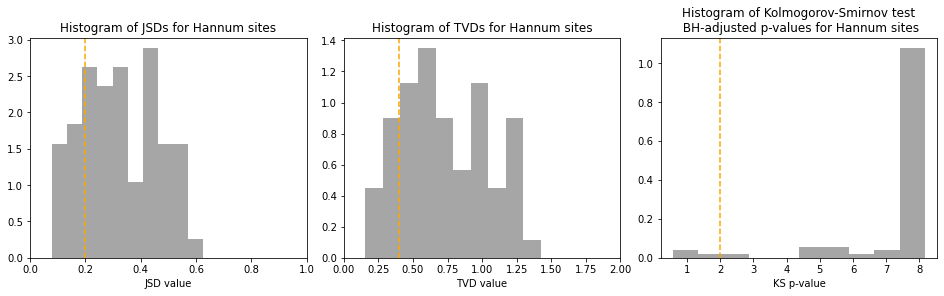

In [18]:
from statsmodels.stats.multitest import multipletests
#supplement

fig = plt.figure(figsize=(13, 4), constrained_layout=True)
gs = GridSpec(1, 3, figure=fig) 
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# ax5 - overall PSI hist
psis = calculate_shift(np.array(Xa1_clock), np.array(Xa2_clock), metric_type='jsd')

ax0.set_title('Histogram of JSDs for Hannum sites')
ax0.hist(psis, density=True, alpha=0.7, color='grey')
ax0.axvline(0.2, color='orange', ls='--')
ax0.set_xlim([0, 1])
ax0.set_xlabel('JSD value')

psis = calculate_shift(np.array(Xa1_clock), np.array(Xa2_clock), metric_type='tvd')

ax1.set_title('Histogram of TVDs for Hannum sites')
ax1.hist(psis, density=True, alpha=0.7, color='grey')
ax1.axvline(0.4, color='orange', ls='--')
ax1.set_xlim([0, 2])
ax1.set_xlabel('TVD value')

ks, ksp = calculate_shift(np.array(Xa1_clock), np.array(Xa2_clock), metric_type='ks')
kspa = multipletests(ksp, method='hs')[1]
ax2.set_title('Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Hannum sites')
ax2.hist(-np.log10(kspa), density=True, alpha=0.7, color='grey')
ax2.axvline(-np.log10(0.01), color='orange', ls='--')
#ax2.set_xlim([0, 1])
ax2.set_xlabel('KS p-value')
plt.show()

In [15]:
def inverse_train_test_procedure(model, 
                                 X_train, y_train, 
                                 X_test, y_test=None, 
                                 params={},
                                 verbose=1):
    from sklearn.metrics import mean_absolute_error, r2_score
    # For Aging train/test sets
    #step 1: usual model fit
    model1 = model(**params)
    model1.fit(X_train, y_train)

    y_train_predict_step1 = model1.predict(X_train)
    y_test_predict_step1 = model1.predict(X_test)

    print('Step 1 results:')
    r2_tr_step1 = round(r2_score(y_train, y_train_predict_step1), 3)
    mae_tr_step1 = round(mean_absolute_error(y_train, y_train_predict_step1), 3)
    print(f'R2 train = {r2_tr_step1}')
    print(f'MAE train = {mae_tr_step1}')
    if y_test is not None:
        r2_te_step1 = round(r2_score(y_test, y_test_predict_step1), 3)
        mae_te_step1 = round(mean_absolute_error(y_test, y_test_predict_step1), 3)
        print(f'R2 test = {r2_te_step1}')
        print(f'MAE test = {mae_te_step1}')
    print('-'*30)

    #step 2: use the predicted y as response for fitting model on test, then predict train
    model2 = model(**params)
    model2.fit(X_test, y_test_predict_step1)

    y_train_predict_step2 = model2.predict(X_test)
    y_test_predict_step2 = model2.predict(X_train)

    print('Step 2 results:')
    if y_test is not None:
        r2_tr_step2 = round(r2_score(y_test, y_train_predict_step2), 3)
        mae_tr_step2 = round(mean_absolute_error(y_test, y_train_predict_step2), 3)
        print(f'R2 train = {r2_tr_step2}')
        print(f'MAE train = {mae_tr_step2}')
    
    r2_te_step2 = round(r2_score(y_train, y_test_predict_step2), 3)
    mae_te_step2 = round(mean_absolute_error(y_train, y_test_predict_step2), 3)
    print(f'R2 test = {r2_te_step2}')
    print(f'MAE test = {mae_te_step2}')
    print('-'*30) 
    
    return (y_train_predict_step1, 
            y_test_predict_step1, 
            y_train_predict_step2,
            y_test_predict_step2)

Step 1 results:
R2 train = 0.971
MAE train = 2.767
R2 test = 0.874
MAE test = 3.883
------------------------------
Step 2 results:
R2 train = 0.874
MAE train = 3.887
R2 test = 0.971
MAE test = 2.793
------------------------------


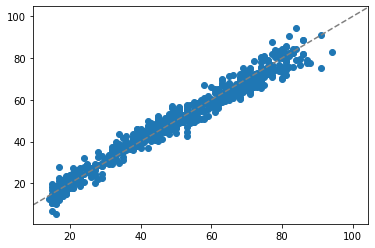

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train=Xa1_clock, y_train=ya1, 
                                 X_test=Xa2_clock, y_test=ya2, 
                                 params={},
                                 verbose=1)

plt.scatter(ya1, y_test_predict_step2)
plt.axline([20, 20], [100, 100], color='grey', ls='--')

Step 1 results:
R2 train = 0.904
MAE train = 3.478
R2 test = 0.956
MAE test = 3.438
------------------------------
Step 2 results:
R2 train = 0.957
MAE train = 3.412
R2 test = 0.902
MAE test = 3.503
------------------------------


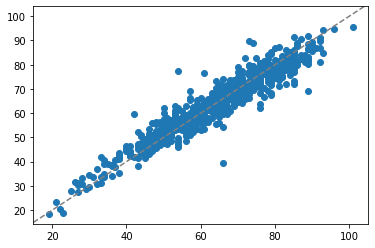

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train=Xa2_clock, y_train=ya2, 
                                 X_test=Xa1_clock, y_test=ya1, 
                                 params={},
                                 verbose=1)

plt.scatter(ya2, y_test_predict_step2)
plt.axline([20, 20], [100, 100], color='grey', ls='--')

# Other

In [2]:
#human GRCh37/hg19 source=(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3695075/)

p = '/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/data_joined.csv'
dfa = pd.read_csv(p, index_col=0)
meta = pd.read_csv('/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/descriptions_samples.csv', 
                   index_col=0)
dfa = dfa[meta.index]
print('Age, N sites', len(dfa.index))

Age, N sites 450203


In [3]:
#corr block
#reprogramming data GRCh37/hg19 source=(https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1413299111&file=pnas.201413299SI.pdf)
dfr = pd.read_csv('./data/GSE54848/data.csv', index_col=0)
metr = pd.read_csv('data/GSE54848/GSE54848_metadata.csv', index_col=0).loc[dfr.columns]
mapper = dict(zip(metr.title.apply(lambda x: x.split('_')[0]).unique(), 
                  [0, 3, 7, 11, 15, 20 ,28, 35, 42, 49, 50, 50]))
metr['age'] = metr.title.apply(lambda x: x.split('_')[0]).map(mapper)
print('Rep, N sites', len(dfr.index))

Rep, N sites 485577


In [4]:
#common_sites
common_sites = dfa.index.intersection(dfr.index)

dfa = dfa.loc[common_sites]
dfr = dfr.loc[common_sites]

In [5]:
#get clocks
#read all clock models
paths = glob('methylclock/data/*.rda')
stoplist = ['coefLeeGA', 'coefTL']
clocks = {}
for p in paths:
    name = splitext(basename(p))[0]
    if name in stoplist:
        continue
    if not(name.__contains__('coef')):
        continue
    rda = pyreadr.read_r(p) # also works for Rds, rda
    clocks[name] = rda[name].set_index('CpGmarker')

In [6]:
#predict aging
model_predictions = {}
for name, clock in tqdm(clocks.items()):
    sites = clock.index.intersection(dfa.index)
    if len(sites) > 50000:
        continue
    ages = []
    means = []
    for s in dfa.columns:
        row = dfa.loc[sites, s]
        avg = row.mean()
        ## DANGER ZONE: REMOVE SAMPLE AVG 
        # repday = meta_filtered.loc[row.name]['age']
        # stage_avg = stage_averages[repday]
        # row = row - avg
        ##
        #coef_shift
        w = clock.loc[sites, 'CoefficientTraining']
        #w = w - w.mean()
        age = (row * w).sum()
        if '(Intercept)' in clock.index:
            age += clock.loc['(Intercept)', 'CoefficientTraining']
        ages.append(age)   
        means.append(avg)  

    #scaling       
    ages = np.array(ages)
    ages = (ages - ages.min()) 
    ages = ages / ages.max() * 60

    meta['eAge' + f'_{name}'] = ages
    meta['averages'] = means
    model_predictions[name] = ages
groupa = meta.groupby('age').mean().filter(regex='eAge')

  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_29332/3707657252.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupa = meta.groupby('age').mean().filter(regex='eAge')


In [7]:
#predict reprogramming
model_predictions = {}
for name, clock in tqdm(clocks.items()):
    sites = clock.index.intersection(dfr.index)
    if len(sites) > 50000:
        continue
    ages = []
    means = []
    for s in dfr.columns:
        row = dfr.loc[sites, s]
        avg = row.mean()
        ## DANGER ZONE: REMOVE SAMPLE AVG 
        # repday = meta_filtered.loc[row.name]['age']
        # stage_avg = stage_averages[repday]
        # row = row - avg
        ##
        #coef_shift
        w = clock.loc[sites, 'CoefficientTraining']
        #w = w - w.mean()
        age = (row * w).sum()
        if '(Intercept)' in clock.index:
            age += clock.loc['(Intercept)', 'CoefficientTraining']
        ages.append(age)   
        means.append(avg)  

    #scaling       
    ages = np.array(ages)
    ages = (ages - ages.min()) 
    ages = ages / ages.max() * 60

    metr['eAge' + f'_{name}'] = ages
    metr['averages'] = means
    model_predictions[name] = ages
groupr = metr.groupby('age').mean().filter(regex='eAge')

  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_29332/2508590108.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupr = metr.groupby('age').mean().filter(regex='eAge')


In [71]:
# sub = meta[['averages', 'eAge_coefHannum', 'eAge_coefHorvath', 'age']]

# g = sns.lmplot(x='averages', y='eAge_coefHorvath', data=sub)
# plt.xlabel('Reprogramming average methylation', fontsize=14)
# plt.ylabel('Horvath clocks, predicted eAge', fontsize=14)
# def annotate(data, **kws):
#     from scipy import stats
#     r, p = stats.pearsonr(data['averages'], data['eAge_coefHorvath'])
#     ax = plt.gca()
#     ax.text(.25, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
#             transform=ax.transAxes, fontsize = 14)
    
# g.map_dataframe(annotate)
# plt.show()

In [10]:
#Aging process
# plt.figure(figsize=(13,5))
# #plt.scatter(times, ages)
# for name in groupr.columns:
#     n_params = len(clocks[name.split('_')[1]].index)
#     lbl = name.split('_coef')[1]
#     r = np.round(np.corrcoef(group.index.tolist(), group[name])[0, 1], 2)
#     plt.plot(group.index.tolist(), group[name], label=f'{lbl}: {n_params} parameters, r={r}' ) # average plot
# plt.title('eAge changes under aging according to different clocks (data from GSE87571)', fontsize=14)
# plt.xlabel('Day', fontsize=14)
# plt.ylabel('eAge', fontsize=14)
# plt.xticks(rotation=0, fontsize=14)
# plt.yticks(rotation=0, fontsize=14)
# plt.grid(alpha=0.3)
# plt.legend(loc=(1.02, 0.25))
# # plt.savefig('figs/clocks_aging.png', dpi=300, bbox_inches='tight')
# plt.show()

In [19]:
cname = 'coefHorvath'
clock = clocks[cname]
sites = clock.index.intersection(dfa.index)

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

#scaling?
Xa_clock = Xa_clock - Xa_clock.mean(0)
Xr_clock = Xr_clock - Xr_clock.mean(0)

In [20]:
meta['state'] = 'aging' + '_' + meta['age'].astype(str)
metr['state'] = 'rep' + '_' + metr['age'].astype(str)
met_melt = meta.append(metr)

/tmp/ipykernel_29332/3026777716.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met_melt = meta.append(metr)


In [21]:
melt = Xa_clock.sample(5).append(Xr_clock)
lbls = met_melt['state'].loc[melt.index]
melt.index = melt.index + '_' + lbls

/tmp/ipykernel_29332/1793212538.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  melt = Xa_clock.sample(5).append(Xr_clock)


In [23]:
# sns.clustermap(melt.T.corr(), metric='correlation', vmax=1, vmin=0.7, cmap='coolwarm', )

In [24]:
#do pca now

pca = PCA(3)

# Assumption: reprogramming is distributed as aging
# Xpa = pca.fit_transform(Xa_clock)
# Xpr = pca.transform(Xr_clock)

# Assumption: reprogramming is something other than aging
pca.fit(Xa_clock.append(Xr_clock))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

/tmp/ipykernel_29332/1674905582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca.fit(Xa_clock.append(Xr_clock))


In [25]:
pvar = np.round(pca.explained_variance_ratio_, 2)

In [26]:
ya = meta[f'eAge_{cname}']
yr = metr[f'eAge_{cname}']

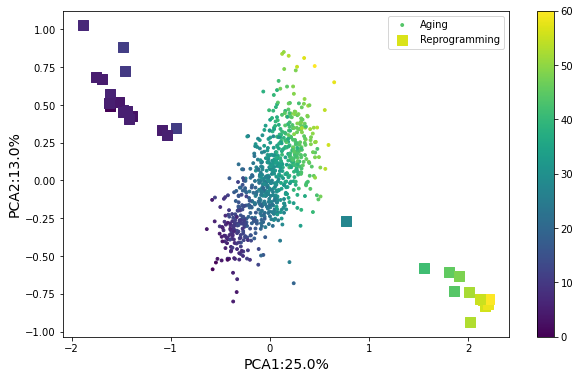

In [27]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=8, label='Aging')
plt.scatter(Xpr[:, 0], Xpr[:, 1], c=yr, marker='s', s=100, label='Reprogramming')
plt.xlabel(f'PCA1:{pvar[0]*100}%', fontsize=14)
plt.ylabel(f'PCA2:{pvar[1]*100}%', fontsize=14)
plt.legend()
plt.colorbar()

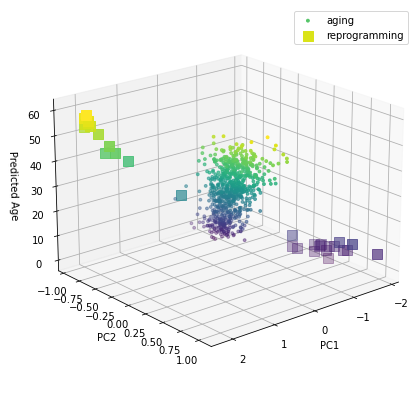

In [24]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(projection='3d')
# ax.scatter(Xpa[:, 0], Xpa[:, 1], Xpa[:, 2], c=ya, s=8)
# ax.scatter(Xpr[:, 0], Xpr[:, 1], Xpr[:, 2], c=yr, marker='s', s=100)
ax.scatter(Xpa[:, 0], Xpa[:, 1], ya, c=ya, s=8, label='aging')
ax.scatter(Xpr[:, 0], Xpr[:, 1], yr, c=yr, marker='s', s=100, label='reprogramming')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Predicted Age')
ax.view_init(20, 50)
ax.legend()